In [1]:
#This is the function to get the blue box position
def get_box_data(index, hdf5_data):
    """
    get `left, top, width, height` of each picture
    :param index:
    :param hdf5_data:
    :return:
    """
    meta_data = dict()
    meta_data['height'] = []
    meta_data['label'] = []
    meta_data['left'] = []
    meta_data['top'] = []
    meta_data['width'] = []

    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(int(hdf5_data[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = hdf5_data['/digitStruct/bbox'][index]
    hdf5_data[box[0]].visititems(print_attrs)
    return meta_data

def get_name(index, hdf5_data):
    name = hdf5_data['/digitStruct/name']
    return ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])

In [2]:
#This is to read the image from file into python
from scipy import misc
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

X_train=[]
directory="C:\\Users\\Mert Ketenci\\Desktop\\train\\train\\"
img_type=".png"
for i in range(1,500):
    image_name=[i,img_type]
    values = ''.join(str(v) for v in image_name)
    folder=[directory,values] 
    folder=''.join(folder)
    image = misc.imread(folder)
    X_train.append(image)


C:\Anaconda3\envs\dlenv\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


In [61]:
# Run this cell will be able to provide you the cropped image in 54*54*3 format
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

mat_data = h5py.File('C:\\Users\\Mert Ketenci\\Desktop\\train\\train\\digitStruct.mat')
size = mat_data['/digitStruct/name'].size

#print (box)
label_Final = []
Pic_crop_Final = []
for i in range(499):
    Array = np.array(X_train[i])
    pic = get_name(i, mat_data)
    box = get_box_data(i, mat_data)
    label = box['label']
    label_Final.append(''.join(str(int(x%10)) for x in label))
 
    Test = label_Final[0]

    #Increase location by 30%
    
    H = int(round((max(box['top'])+max(box['height'])) *1.03))
    L = int(round (min(box['left']) *(0.97)))
    if L<0:
        L =0
    T = int(round (min(box['top'])*(0.97)))
    if T<0:
        T = 0
    W = int(round((max (box ['left'])+ max(box['width']))*1.03))

    Pic_crop = Array [T:H,L:W]


    #resize data and append
    res_Pic_crop = cv2.resize(Pic_crop, dsize=(54, 54), interpolation=cv2.INTER_CUBIC)
    Pic_crop_Final.append(res_Pic_crop)


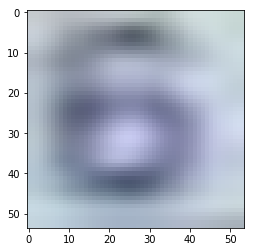

In [62]:
plt.imshow(Pic_crop_Final[34])


In [56]:
#Pic_crop_Final = np.asarray(Pic_crop_Final).reshape(499,54,54,3) 

In [82]:
label=[]
length=[]
for i in range(len(label_Final)):
    label.append([int(x) for x in label_Final[i]])
    length.append(len(label[-1])) 


In [118]:
thats_hot=np.zeros((499,5,11), dtype=int)
for i in range(499):
    for j in range(len(label[i])):
        thats_hot[i][j][label[i][j]]=1
        for j in range(len(label[i]),5):
            thats_hot[i][j][10]=1
            

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [120]:
import tensorflow as tf
tf.reset_default_graph()


x = tf.placeholder(tf.float32, shape=(None,54,54,3))
length_labels = tf.placeholder(tf.int64, shape=(None,None,))
digits_labels =  tf.placeholder(tf.int64, shape=(None,None,None))
drop_rate=0.5

with tf.variable_scope('hidden1'):
    conv = tf.layers.conv2d(x, filters=48, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
    hidden1 = pool  # 27 * 27 * 48
    # print(hidden1.shape)

with tf.variable_scope('hidden2'):
    conv = tf.layers.conv2d(hidden1, filters=64, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
    hidden2 = pool  # 27 * 27 * 64
    # print(hidden2.shape)

with tf.variable_scope('hidden3'):
    conv = tf.layers.conv2d(hidden2, filters=128, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
    hidden3 = pool  # 14 * 14 * 128
    # print(hidden3.shape)

with tf.variable_scope('hidden4'):
    conv = tf.layers.conv2d(hidden3, filters=160, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
    hidden4 = pool  # 14 * 14 *160
    # print(hidden4.shape)

with tf.variable_scope('hidden5'):
    conv = tf.layers.conv2d(hidden4, filters=192, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
    hidden5 = pool  # 7 * 7 * 192
    # print(hidden5.shape)

with tf.variable_scope('hidden6'):
    conv = tf.layers.conv2d(hidden5, filters=192, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
    hidden6 = pool  # 7 * 7 * 192
    # print(hidden6.shape)

with tf.variable_scope('hidden7'):
    conv = tf.layers.conv2d(hidden6, filters=192, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=2, padding='same')
    hidden7 = pool  # 4 * 4 * 192
    # print(hidden7.shape)

with tf.variable_scope('hidden8'):
    conv = tf.layers.conv2d(hidden7, filters=192, kernel_size=[5, 5], padding='same')
    norm = tf.layers.batch_normalization(conv)
    activation = tf.nn.relu(norm)
    pool = tf.layers.max_pooling2d(activation, pool_size=[2, 2], strides=1, padding='same')
    hidden8 = pool  # 4 * 4 * 192

flatten = tf.reshape(hidden8, [-1, 4 * 4 * 192])

with tf.variable_scope('hidden9'):
    dense = tf.layers.dense(flatten, units=3072, activation=tf.nn.relu)
    dropout = tf.layers.dropout(dense, rate=drop_rate)
    hidden9 = dropout

with tf.variable_scope('hidden10'):
    dense = tf.layers.dense(hidden9, units=3072, activation=tf.nn.relu)
    dropout = tf.layers.dropout(dense, rate=drop_rate)
    hidden10 = dropout

with tf.variable_scope('digit_length'):
    dense = tf.layers.dense(hidden10, units=7)
    length = dense

with tf.variable_scope('digit1'):
    dense = tf.layers.dense(hidden10, units=11)
    digit1 = dense

with tf.variable_scope('digit2'):
    dense = tf.layers.dense(hidden10, units=11)
    digit2 = dense

with tf.variable_scope('digit3'):
    dense = tf.layers.dense(hidden10, units=11)
    digit3 = dense

with tf.variable_scope('digit4'):
    dense = tf.layers.dense(hidden10, units=11)
    digit4 = dense

with tf.variable_scope('digit5'):
    dense = tf.layers.dense(hidden10, units=11)
    digit5 = dense

length_logits, digits_logits = length, tf.stack([digit1, digit2, digit3, digit4, digit5], axis=1)

# length_labels = tf.one_hot(length_labels, 7)
# print(length_logits.shape, length_labels.shape)
length_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=length_labels, logits=length_logits))
digit1_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=digits_labels[:, 0], logits=digits_logits[:, 0, :]))
digit2_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=digits_labels[:, 1], logits=digits_logits[:, 1, :]))
digit3_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=digits_labels[:, 2], logits=digits_logits[:, 2, :]))
digit4_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=digits_labels[:, 3], logits=digits_logits[:, 3, :]))
digit5_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits (labels=digits_labels[:, 4], logits=digits_logits[:, 4, :]))
loss = length_cross_entropy + digit1_cross_entropy + digit2_cross_entropy + digit3_cross_entropy + digit4_cross_entropy + digit5_cross_entropy

train_step = tf.train.AdamOptimizer(1e-6).minimize(loss)

init = tf.initialize_all_variables()



length_predictions = tf.argmax(length_logits, axis=1)
digits_predictions = tf.argmax(digits_logits, axis=2)



num_train = 499
batch_size = 32
num_batch = num_train//batch_size

with tf.Session() as sess:
    sess.run(init)
    for e in range(20):
        for i in range(num_batch):
            batch_x, batch_digits, batch_length = Pic_crop_Final[i*batch_size:(i+1)*batch_size], thats_hot[i*batch_size:(i+1)*batch_size], hot_length[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x:batch_x , length_labels:batch_length ,digits_labels:batch_digits})
            length_cross_entropy_tf = sess.run(length_cross_entropy, feed_dict={x:Pic_crop_Final , length_labels:hot_length ,digits_labels:thats_hot})
            digit1_cross_entropy_tf = sess.run(digit1_cross_entropy, feed_dict={x:Pic_crop_Final , length_labels:hot_length ,digits_labels:thats_hot})
            digit2_cross_entropy_tf = sess.run(digit2_cross_entropy, feed_dict={x:Pic_crop_Final , length_labels:hot_length ,digits_labels:thats_hot})
            digit3_cross_entropy_tf = sess.run(digit3_cross_entropy, feed_dict={x:Pic_crop_Final , length_labels:hot_length ,digits_labels:thats_hot})
            digit4_cross_entropy_tf = sess.run(digit4_cross_entropy, feed_dict={x:Pic_crop_Final , length_labels:hot_length ,digits_labels:thats_hot})
            digit5_cross_entropy_tf = sess.run(digit5_cross_entropy, feed_dict={x:Pic_crop_Final , length_labels:hot_length ,digits_labels:thats_hot})
            loss_tf = sess.run(loss, feed_dict={x:Pic_crop_Final , length_labels:hot_length ,digits_labels:thats_hot})
            print("total loss",loss_tf)
            print("length loss",length_cross_entropy_tf)
            print("digit1 loss",digit1_cross_entropy_tf)
            print("digit2 loss",digit2_cross_entropy_tf)
            print("digit3 loss",digit3_cross_entropy_tf)
            print("digit4 loss",digit4_cross_entropy_tf)
            print("digit5 loss",digit5_cross_entropy_tf)

total loss 24.447567
length loss 4.3473907
digit1 loss 5.3463206
digit2 loss 3.574989
digit3 loss 1.9987197
digit4 loss 4.88852
digit5 loss 4.291627
total loss 23.412613
length loss 4.1619215
digit1 loss 5.264053
digit2 loss 3.509579
digit3 loss 1.905143
digit4 loss 4.6067243
digit5 loss 3.965193
total loss 22.421589
length loss 3.9862616
digit1 loss 5.1730886
digit2 loss 3.4477828
digit3 loss 1.824468
digit4 loss 4.3406405
digit5 loss 3.6493466
total loss 21.46457
length loss 3.8207545
digit1 loss 5.0791807
digit2 loss 3.3864262
digit3 loss 1.7571652
digit4 loss 4.080794
digit5 loss 3.3402503
total loss 20.552902
length loss 3.6652076
digit1 loss 4.9899936
digit2 loss 3.325433
digit3 loss 1.6986123
digit4 loss 3.8301556
digit5 loss 3.0435
total loss 19.67981
length loss 3.518546
digit1 loss 4.901572
digit2 loss 3.2654846
digit3 loss 1.6526856
digit4 loss 3.5872247
digit5 loss 2.7542956
total loss 18.84305
length loss 3.3829503
digit1 loss 4.8129053
digit2 loss 3.2082384
digit3 loss 1.

digit4 loss 0.38732222
digit5 loss 0.08553162
total loss 7.748716
length loss 1.2410444
digit1 loss 2.210677
digit2 loss 2.4106436
digit3 loss 1.4167454
digit4 loss 0.38570276
digit5 loss 0.08390317
total loss 7.7266455
length loss 1.2372606
digit1 loss 2.2004228
digit2 loss 2.4065216
digit3 loss 1.4160255
digit4 loss 0.38410965
digit5 loss 0.082305536
total loss 7.7039523
length loss 1.2334245
digit1 loss 2.1893454
digit2 loss 2.4024644
digit3 loss 1.4152541
digit4 loss 0.382672
digit5 loss 0.08079207
total loss 7.6826935
length loss 1.2299184
digit1 loss 2.1790235
digit2 loss 2.398719
digit3 loss 1.41438
digit4 loss 0.381432
digit5 loss 0.07922009
total loss 7.6610317
length loss 1.2257257
digit1 loss 2.1685302
digit2 loss 2.3951917
digit3 loss 1.4136429
digit4 loss 0.38029736
digit5 loss 0.0776441
total loss 7.6387086
length loss 1.2215408
digit1 loss 2.1568875
digit2 loss 2.3919106
digit3 loss 1.4128467
digit4 loss 0.3793363
digit5 loss 0.07618679
total loss 7.6167803
length loss 1

total loss 7.2332315
length loss 1.134646
digit1 loss 1.9897157
digit2 loss 2.3290849
digit3 loss 1.3825512
digit4 loss 0.35907057
digit5 loss 0.038163234
total loss 7.2306185
length loss 1.1339631
digit1 loss 1.9888879
digit2 loss 2.3289664
digit3 loss 1.3821768
digit4 loss 0.35893378
digit5 loss 0.037689943
total loss 7.228399
length loss 1.1334974
digit1 loss 1.9881492
digit2 loss 2.3287694
digit3 loss 1.3819896
digit4 loss 0.35877842
digit5 loss 0.037215304
total loss 7.2255464
length loss 1.1327362
digit1 loss 1.9874531
digit2 loss 2.3284168
digit3 loss 1.3816383
digit4 loss 0.35857642
digit5 loss 0.036726035
total loss 7.221779
length loss 1.1312649
digit1 loss 1.9868352
digit2 loss 2.328009
digit3 loss 1.3810406
digit4 loss 0.35833746
digit5 loss 0.036292166
total loss 7.2179346
length loss 1.12995
digit1 loss 1.9859983
digit2 loss 2.3275125
digit3 loss 1.3804375
digit4 loss 0.35810596
digit5 loss 0.035930846
total loss 7.2139616
length loss 1.1287472
digit1 loss 1.9851528
digit

total loss 7.09846
length loss 1.094871
digit1 loss 1.9590385
digit2 loss 2.3094301
digit3 loss 1.3605993
digit4 loss 0.35111764
digit5 loss 0.02340377
total loss 7.096524
length loss 1.0944726
digit1 loss 1.9585341
digit2 loss 2.3090246
digit3 loss 1.3602393
digit4 loss 0.3509824
digit5 loss 0.023271354
total loss 7.0950537
length loss 1.094282
digit1 loss 1.9581957
digit2 loss 2.3086996
digit3 loss 1.3598983
digit4 loss 0.3508842
digit5 loss 0.023093056
total loss 7.093486
length loss 1.0938929
digit1 loss 1.9579662
digit2 loss 2.3083665
digit3 loss 1.359559
digit4 loss 0.35081375
digit5 loss 0.022887113
total loss 7.0916414
length loss 1.093363
digit1 loss 1.9576423
digit2 loss 2.30807
digit3 loss 1.3591405
digit4 loss 0.35071036
digit5 loss 0.022715114
total loss 7.089268
length loss 1.0924802
digit1 loss 1.9571732
digit2 loss 2.3077214
digit3 loss 1.3587465
digit4 loss 0.35060334
digit5 loss 0.022543343
total loss 7.0869694
length loss 1.0914966
digit1 loss 1.9567709
digit2 loss 2

total loss 7.0081577
length loss 1.0678095
digit1 loss 1.9420815
digit2 loss 2.2936034
digit3 loss 1.3415618
digit4 loss 0.34629306
digit5 loss 0.016808689
total loss 7.008319
length loss 1.0683699
digit1 loss 1.9418674
digit2 loss 2.293636
digit3 loss 1.3414791
digit4 loss 0.34626973
digit5 loss 0.016696848
total loss 7.0076213
length loss 1.0684109
digit1 loss 1.9417298
digit2 loss 2.2934308
digit3 loss 1.3412759
digit4 loss 0.34618717
digit5 loss 0.0165862
total loss 7.0052047
length loss 1.0671452
digit1 loss 1.9416066
digit2 loss 2.2931535
digit3 loss 1.3407212
digit4 loss 0.34608415
digit5 loss 0.016493829
total loss 7.0024977
length loss 1.0659747
digit1 loss 1.9412309
digit2 loss 2.2926977
digit3 loss 1.3402157
digit4 loss 0.3459468
digit5 loss 0.016432514
total loss 6.9998136
length loss 1.065012
digit1 loss 1.9409295
digit2 loss 2.291931
digit3 loss 1.3397716
digit4 loss 0.34579524
digit5 loss 0.016374167
total loss 6.9977465
length loss 1.0644484
digit1 loss 1.9405209
digit2

total loss 6.9292493
length loss 1.0453378
digit1 loss 1.92782
digit2 loss 2.2768104
digit3 loss 1.3239342
digit4 loss 0.34217843
digit5 loss 0.013168141
total loss 6.928761
length loss 1.0456008
digit1 loss 1.927679
digit2 loss 2.276542
digit3 loss 1.3237199
digit4 loss 0.34211972
digit5 loss 0.013099819
total loss 6.9280405
length loss 1.0455505
digit1 loss 1.9276958
digit2 loss 2.27626
digit3 loss 1.3234289
digit4 loss 0.34208822
digit5 loss 0.013017183
total loss 6.926798
length loss 1.0452524
digit1 loss 1.9275098
digit2 loss 2.275985
digit3 loss 1.3230795
digit4 loss 0.3420126
digit5 loss 0.012959005
total loss 6.924484
length loss 1.0442926
digit1 loss 1.9270103
digit2 loss 2.275633
digit3 loss 1.3226993
digit4 loss 0.34194934
digit5 loss 0.012899012
total loss 6.9222064
length loss 1.0431963
digit1 loss 1.9265949
digit2 loss 2.275416
digit3 loss 1.3222418
digit4 loss 0.34191802
digit5 loss 0.012839596
total loss 6.9210086
length loss 1.0427592
digit1 loss 1.9263248
digit2 loss 

In [174]:
a=Pic_crop_Final[i*batch_size:(i+1)*batch_size]